### Libraries

!pip install pytorch-metric-learning

In [1]:
import torch
import tqdm
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
from torchvision import datasets, transforms
from pytorch_metric_learning import distances, losses, miners, reducers
from sklearn.metrics import f1_score, accuracy_score


### Data

In [11]:
# path where data will be stored
DATA_PATH = r'D:\Users\amira\Documents\projects\face-recognition\data'

device = torch.device("cuda")
IMG_SIZE = 112

transform = transforms.Compose(
    [transforms.RandomCrop(IMG_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     transforms.RandomHorizontalFlip(p=0.5)
     ])

batch_size = 32

train_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'train', image_set = 'funneled', transform = transform, download = True)
#test_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'test', image_set = 'funneled', transform=transform, download = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
test_transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])


In [4]:
lfw_pairs_eval = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=test_transform, image_set = 'funneled', download = True)
eval_dataloader = torch.utils.data.DataLoader(lfw_pairs_eval, shuffle=True, batch_size=32)


Files already downloaded and verified


In [6]:
def train_epoch(train_dataloader,model,criterion,optimizer,loss_optimizer,epoch):
    
    model.train()
    total_loss = 0
    iteration_number= 0
    
    for batch_idx, (img, label) in enumerate(train_dataloader, 0):
        img, label = img.cuda(), label.cuda()
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loss_optimizer.step()

        # Every 20 batches print out the loss
        if batch_idx % 20 == 0 :
            print(
            "Epoch {} Iteration {}: Loss = {}".format(
                epoch, batch_idx, loss
            ))
            iteration_number += 20

        
    total_loss = total_loss/(1+batch_idx)
    
    return total_loss

def validate_epoch(eval_dataloader,model):
    labels = []
    cosine_similarities = []

    for data in eval_dataloader:
        
        model.eval()
        with torch.no_grad():
            
            img1 = data[0].cuda()
            img2 = data[1].cuda()
            labels += list(data[2].numpy().flatten().astype(int))
            
            embedding1 = model(img1)
            embedding2 = model(img2)
            
            cos = nn.CosineSimilarity(dim=1, eps=1e-6)
            cosine_similarities += list(cos(embedding1,embedding2).cpu().numpy())
    
    thresholds = list(np.arange(0, 1.0, 0.01))

    f1_scores = [f1_score(labels, cosine_similarities > t) for t in thresholds]
    acc_scores = [accuracy_score(labels, cosine_similarities > t) for t in thresholds]

    max_f1 = max(f1_scores)
    max_f1_index = f1_scores.index(max_f1)

    max_acc = max(acc_scores)
    max_acc_index = acc_scores.index(max_acc)

    print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))
    print("At threshold : {}, we get a maximum of accuracy : {} ".format(round(thresholds[max_acc_index],4),max_acc))
        

def save_model(model,model_name, save_path,best_loss):
    #name = "best_{}".format(model_name) + "_{}.pth".format(best_loss, ".3f")
    experiment_name = os.path.join(save_path,  "best_{}.pth".format(model_name))
    torch.save(model.state_dict(),experiment_name)

### Model

In [7]:
class Net(nn.Module):    
    def __init__(self, base_net, emb_dim=128, feat_dim=512):
        super(Net, self).__init__()
        self.base_net = base_net
        
        try:
            in_dim = base_net.fc.in_features
        except NameError as e:
            if feat_dim is not None:
                in_dim = feat_dim
            else:
                raise Exception("Neither does the base_net hase fc layer nor in_dim is specificed")
        self.base_net.fc = nn.Linear(in_dim, emb_dim)
        

    def forward(self, x):
        output = self.base_net(x)
        #output = self.dense(output)
        return output

### Training without weight decay

In [13]:
from torchvision.models import resnet18

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'
exp_name = "resnet18_arcface"

base_net = resnet18(pretrained=True).to(device)
model = Net(base_net, emb_dim=512).to(device)


In [15]:
optimizer = optim.AdamW(model.parameters(), lr=0.00003)

criterion = losses.ArcFaceLoss(num_classes=5749, embedding_size=512, scale=64, margin=0.5).to(device)
loss_optimizer = torch.optim.Adam(criterion.parameters(), lr=1e-4)

In [ ]:
n_epochs = 50

train_losses = []
best_loss = np.inf

for epoch in range(n_epochs):
    train_loss = train_epoch(train_dataloader,model,criterion,optimizer,loss_optimizer,epoch)
    validate_epoch(eval_dataloader,model)
    
    if train_loss < best_loss:
        best_loss = train_loss
        save_model(model,exp_name,SAVE_PATH,best_loss)

    train_losses.append(train_loss)

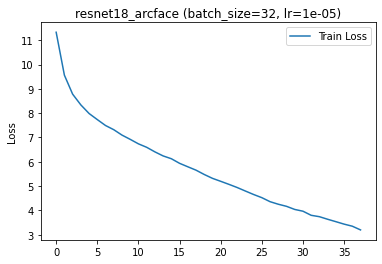

In [18]:
plt.title(exp_name + " (batch_size={}, lr={})".format(32, 0.00001))
plt.plot(train_losses, label='Train Loss')
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#### Evaluation

Cosine_Similarity : 0.9821197986602783
Detected : similar


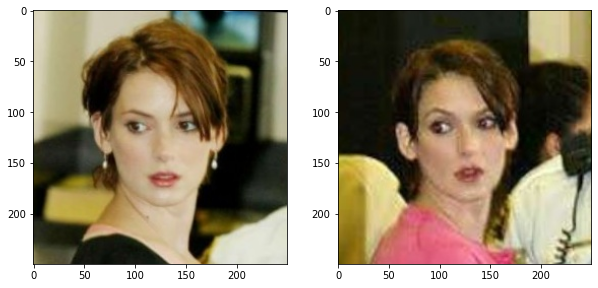

In [19]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0006.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0002.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.68 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  

Cosine_Similarity : 0.9818000793457031
Detected : similar


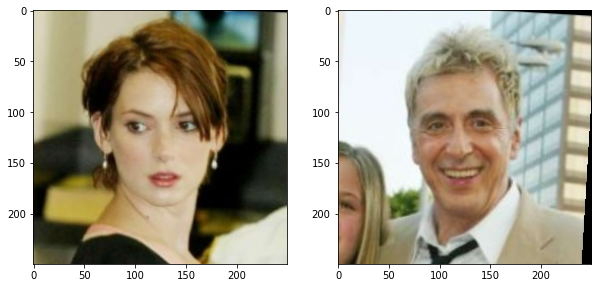

In [20]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0006.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Al_Pacino\Al_Pacino_0003.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.68 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  